In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "HB-other"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn006961,MGCSHGGRGSKRGNGSGDPDGDCGKYTRYTAEQVEVLEKVFAECPK...,134,1
1,Achn085431,MKSEIAGSLGLTEKQVSGWFCHRRLKDKNSQHGEAPANGRQDRSSG...,395,1
2,Achn133111,MDTILQEHNTQVPARDVLEALAEKFSASEERSGTIVVQMKQVWNWF...,355,1
3,Achn159891,MAAASSFYSPMALRYLPAPYTHRPSVSHLRANLLLPRYPFRRPVVV...,800,1
4,Achn179461,MVESYAVHSEDNNTPPEKSKKRRFKTPSQVEALEKFYSEHKYPSEE...,493,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
3425,0.000000,0.004132,0.000000,0.008264,0.000000,0.004132,0.000000,0.000000,0.012397,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1948,0.013841,0.000000,0.003460,0.006920,0.006920,0.006920,0.003460,0.006920,0.003460,0.000000,...,0.000000,0.003460,0.000000,0.000000,0.003460,0.000000,0.0,0.0,0.0,0.0
3413,0.006466,0.000000,0.002155,0.002155,0.002155,0.002155,0.000000,0.004310,0.000000,0.002155,...,0.002155,0.000000,0.002155,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3052,0.005682,0.008523,0.005682,0.005682,0.002841,0.000000,0.002841,0.000000,0.000000,0.002841,...,0.000000,0.002841,0.002841,0.005682,0.000000,0.002841,0.0,0.0,0.0,0.0
4391,0.003115,0.003115,0.003115,0.009346,0.000000,0.000000,0.000000,0.012461,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003115,0.000000,0.0,0.0,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3616, 441)
X_test: (904, 441)
y_train: (3616,)
y_test: (904,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.4688 - loss: 0.6932

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5288 - loss: 0.6910   

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5442 - loss: 0.6893 - val_accuracy: 0.7528 - val_loss: 0.6299


Epoch 2/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7188 - loss: 0.6400

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8069 - loss: 0.5690

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8117 - loss: 0.5472 - val_accuracy: 0.8757 - val_loss: 0.3215


Epoch 3/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8438 - loss: 0.2986

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8705 - loss: 0.2981

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8721 - loss: 0.2990 - val_accuracy: 0.8840 - val_loss: 0.3200


Epoch 4/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1591

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9236 - loss: 0.2168

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2212 - val_accuracy: 0.8854 - val_loss: 0.2815


Epoch 5/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.2922

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9170 - loss: 0.2409

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9179 - loss: 0.2333 - val_accuracy: 0.8936 - val_loss: 0.2871


Epoch 6/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.3133

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9250 - loss: 0.2109

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2033 - val_accuracy: 0.9033 - val_loss: 0.2822


Epoch 7/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1476

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9387 - loss: 0.1775

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9384 - loss: 0.1762 - val_accuracy: 0.8923 - val_loss: 0.2861


Epoch 8/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1757

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1630

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9497 - loss: 0.1613 - val_accuracy: 0.9006 - val_loss: 0.2800


Epoch 9/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1135

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 0.1415

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 0.1396 - val_accuracy: 0.9061 - val_loss: 0.2787


Epoch 10/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0746

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9676 - loss: 0.1058

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9658 - loss: 0.1093 - val_accuracy: 0.9047 - val_loss: 0.2788


Epoch 11/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1105

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9669 - loss: 0.1141

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.1127 - val_accuracy: 0.8854 - val_loss: 0.3351


Epoch 12/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0977

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.0922

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9679 - loss: 0.0937 - val_accuracy: 0.8798 - val_loss: 0.3514


Epoch 13/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1538

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9582 - loss: 0.1226

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9613 - loss: 0.1137 - val_accuracy: 0.8812 - val_loss: 0.3674


Epoch 14/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9375 - loss: 0.1096

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0927

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.0868 - val_accuracy: 0.9171 - val_loss: 0.2851


Epoch 15/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0762

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0589

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.0606 - val_accuracy: 0.9171 - val_loss: 0.2892


Epoch 16/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0249

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0441

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0462 - val_accuracy: 0.8992 - val_loss: 0.3583


Epoch 17/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0438

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9716 - loss: 0.0676

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0645 - val_accuracy: 0.9213 - val_loss: 0.2988


Epoch 18/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.1715

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0501

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0439 - val_accuracy: 0.9199 - val_loss: 0.3158


Epoch 19/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0092

29/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0338

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0317 - val_accuracy: 0.9130 - val_loss: 0.3381


Epoch 20/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0189

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0261

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0276 - val_accuracy: 0.9130 - val_loss: 0.3535


Epoch 21/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0096

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0269

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0262 - val_accuracy: 0.9075 - val_loss: 0.3703


Epoch 22/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0229

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0194

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0202 - val_accuracy: 0.8826 - val_loss: 0.4944


Epoch 23/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0491

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0260

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0247 - val_accuracy: 0.9185 - val_loss: 0.3471


Epoch 24/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0098

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0696

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0649 - val_accuracy: 0.9130 - val_loss: 0.3552


Epoch 25/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0298

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0227

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0243 - val_accuracy: 0.9227 - val_loss: 0.3183


Epoch 26/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0065

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0076

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0087 - val_accuracy: 0.9185 - val_loss: 0.3444


Epoch 27/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0026

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0138

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0143 - val_accuracy: 0.9047 - val_loss: 0.4049


Epoch 28/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.1943e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0197    

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0199 - val_accuracy: 0.9185 - val_loss: 0.3544


Epoch 29/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0043

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0089

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0105 - val_accuracy: 0.9157 - val_loss: 0.3638


Epoch 30/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0027

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0233

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0230 - val_accuracy: 0.9213 - val_loss: 0.3568


Epoch 31/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0033

31/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0070

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 0.9102 - val_loss: 0.4133


Epoch 32/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

32/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0044

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9088 - val_loss: 0.4315


Epoch 33/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0020

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9061 - val_loss: 0.4637


Epoch 34/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0112

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0091 - val_accuracy: 0.9088 - val_loss: 0.4594


Epoch 35/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.0078e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0031    

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9199 - val_loss: 0.4189



[Train Accuracy: 99.86% - Test Accuracy: 92.37%]


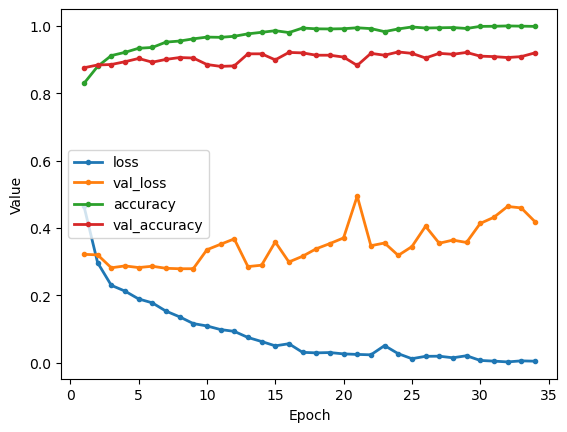

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3425,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1948,0.00000,0.0,0.0,0.0,0.000000,0.0,0.003472,0.003472,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3413,0.00216,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.002160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3052,0.00000,0.0,0.0,0.0,0.002849,0.0,0.000000,0.000000,0.0,0.002849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4391,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3616, 8722)
X_test: (904, 8722)
y_train: (3616,)
y_test: (904,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,233,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,276,353 (8.68 MB)

 Trainable params: 2,276,353 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 21s 474ms/step - accuracy: 0.6094 - loss: 0.6931

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5429 - loss: 0.6930   

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5340 - loss: 0.6927

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5306 - loss: 0.6919

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5358 - loss: 0.6908

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5491 - loss: 0.6885

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5611 - loss: 0.6858 - val_accuracy: 0.9116 - val_loss: 0.5281


Epoch 2/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9219 - loss: 0.5184

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9018 - loss: 0.4862 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9093 - loss: 0.4507

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9167 - loss: 0.4108

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9217 - loss: 0.3803

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9256 - loss: 0.3550

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9277 - loss: 0.3416 - val_accuracy: 0.9420 - val_loss: 0.1430


Epoch 3/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9531 - loss: 0.1220

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9742 - loss: 0.0698 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9786 - loss: 0.0597

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9816 - loss: 0.0539

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9827 - loss: 0.0519

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9833 - loss: 0.0514

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9835 - loss: 0.0513 - val_accuracy: 0.9489 - val_loss: 0.1488


Epoch 4/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0157

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0212 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9959 - loss: 0.0262

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9956 - loss: 0.0258

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9956 - loss: 0.0245

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9957 - loss: 0.0238

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9957 - loss: 0.0235 - val_accuracy: 0.9448 - val_loss: 0.1993


Epoch 5/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0174

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9947 - loss: 0.0098 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9955 - loss: 0.0115

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9962 - loss: 0.0110

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0107

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0104

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9971 - loss: 0.0102 - val_accuracy: 0.9434 - val_loss: 0.2097


Epoch 6/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.0409

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9902 - loss: 0.0160 

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9939 - loss: 0.0112

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9952 - loss: 0.0099

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9957 - loss: 0.0095

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9960 - loss: 0.0091

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9962 - loss: 0.0090 - val_accuracy: 0.9420 - val_loss: 0.1988


Epoch 7/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0020

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0026

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0035

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0040

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0044

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 0.9420 - val_loss: 0.2590


Epoch 8/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0152

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9954 - loss: 0.0064 

19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9966 - loss: 0.0052

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0046

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0041

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0037

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0036 - val_accuracy: 0.9475 - val_loss: 0.2182


Epoch 9/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.9862e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3433e-04 

19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9762e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9598e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0743e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0729e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0547e-04 - val_accuracy: 0.9489 - val_loss: 0.2333


Epoch 10/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.7311e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0795e-04 

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3745e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0465e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4721e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6987e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7781e-04 - val_accuracy: 0.9503 - val_loss: 0.2402


Epoch 11/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.9261e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0012     

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0030

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0038

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0040

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0039

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9406 - val_loss: 0.2508


Epoch 12/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0013

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9254 - val_loss: 0.3392


Epoch 13/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 7.9145e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0052     

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0041

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0035

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0031

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0028

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0026 - val_accuracy: 0.9434 - val_loss: 0.2675


Epoch 14/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6530e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4472e-04 

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6487e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6277e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5333e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4634e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4395e-04 - val_accuracy: 0.9517 - val_loss: 0.2656


Epoch 15/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.1907e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5166e-04 

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6636e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6360e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6021e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5682e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5648e-04 - val_accuracy: 0.9461 - val_loss: 0.2613


Epoch 16/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.9909e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5689e-04 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4468e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4116e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3675e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3325e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3134e-04 - val_accuracy: 0.9517 - val_loss: 0.2682


Epoch 17/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.1170e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5131e-04 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6211e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5402e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4748e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4342e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4142e-04 - val_accuracy: 0.9503 - val_loss: 0.2748


Epoch 18/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.4657e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6077e-05 

19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2289e-05

28/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1052e-05

37/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9754e-05

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9337e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9533e-05 - val_accuracy: 0.9503 - val_loss: 0.2784


Epoch 19/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.1760e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6676e-05 

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1142e-05

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5917e-05

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9072e-05

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2043e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2477e-05 - val_accuracy: 0.9503 - val_loss: 0.2827


Epoch 20/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.8562e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2876e-04 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1741e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9609e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7800e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6443e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6082e-04 - val_accuracy: 0.9503 - val_loss: 0.2874


Epoch 21/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.2887e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6393e-05 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6612e-05

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8942e-05

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3149e-05

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9089e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7642e-05 - val_accuracy: 0.9489 - val_loss: 0.2859


Epoch 22/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.8982e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8040e-04 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6410e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4786e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3816e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2984e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2452e-04 - val_accuracy: 0.9489 - val_loss: 0.2888


Epoch 23/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.1327e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3334e-05 

19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5361e-05

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5917e-05

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5678e-05

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5804e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5804e-05 - val_accuracy: 0.9530 - val_loss: 0.2941


Epoch 24/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.9315e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5250e-05 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8394e-05

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9392e-05

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9859e-05

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0125e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0163e-05 - val_accuracy: 0.9489 - val_loss: 0.2950


Epoch 25/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.6151e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2909e-05 

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5806e-05

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6066e-05

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6005e-05

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6259e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6309e-05 - val_accuracy: 0.9530 - val_loss: 0.2992


Epoch 26/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.9019e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0412e-05 

19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4661e-05

28/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5439e-05

37/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6991e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8178e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8262e-05 - val_accuracy: 0.9503 - val_loss: 0.3007


Epoch 27/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.2806e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9468e-05 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0903e-05

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2348e-05

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2705e-05

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3420e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4123e-05 - val_accuracy: 0.9517 - val_loss: 0.3047


Epoch 28/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.5353e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8567e-05 

18/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6089e-05

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4079e-05

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4026e-05

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7899e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8885e-05 - val_accuracy: 0.9448 - val_loss: 0.3020


Epoch 29/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.6682e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0337e-05 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7352e-05

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7687e-05

33/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7165e-05

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6222e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5591e-05 - val_accuracy: 0.9489 - val_loss: 0.3037


Epoch 30/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.7453e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2113e-05 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4313e-05

25/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1372e-05

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2857e-05

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2492e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1966e-05 - val_accuracy: 0.9489 - val_loss: 0.3209


Epoch 31/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.2082e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4149e-05 

19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6576e-05

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7466e-05

36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8221e-05

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9198e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9598e-05 - val_accuracy: 0.9489 - val_loss: 0.3108


Epoch 32/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.6840e-06

 9/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0204e-05 

17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1503e-05

26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2794e-05

34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4117e-05

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5092e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5413e-05 - val_accuracy: 0.9489 - val_loss: 0.3147


Epoch 33/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.1837e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2731e-05 

19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8343e-05

27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0822e-05

35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1663e-05

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2277e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2332e-05 - val_accuracy: 0.9489 - val_loss: 0.3133



[Train Accuracy: 100.00% - Test Accuracy: 95.80%]


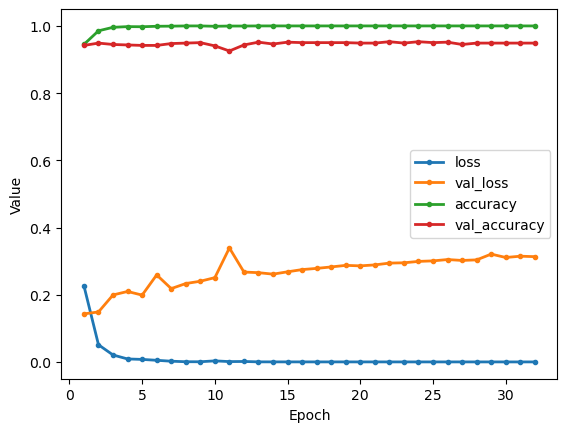

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYW,YYYX,YYYY
3425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,631,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,673,025 (139.90 MB)

 Trainable params: 36,673,025 (139.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 30s 672ms/step - accuracy: 0.6250 - loss: 0.6931

 2/46 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6250 - loss: 0.6929 

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6024 - loss: 0.6931

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5827 - loss: 0.6933

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5711 - loss: 0.6933

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5623 - loss: 0.6933

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5550 - loss: 0.6934

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5484 - loss: 0.6934

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5428 - loss: 0.6934

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5388 - loss: 0.6934

11/46 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5356 - loss: 0.6934

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5327 - loss: 0.6934

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5306 - loss: 0.6933

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5285 - loss: 0.6933

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5260 - loss: 0.6933

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5240 - loss: 0.6933

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5230 - loss: 0.6933

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5225 - loss: 0.6932

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5226 - loss: 0.6932

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5226 - loss: 0.6932

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5225 - loss: 0.6931

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5225 - loss: 0.6931

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5224 - loss: 0.6931

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5224 - loss: 0.6930

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5225 - loss: 0.6930

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5229 - loss: 0.6929

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5237 - loss: 0.6929

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5248 - loss: 0.6928

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5263 - loss: 0.6927

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5278 - loss: 0.6926

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5294 - loss: 0.6926

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5310 - loss: 0.6925

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5327 - loss: 0.6924

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5344 - loss: 0.6923

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5362 - loss: 0.6922

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5381 - loss: 0.6920

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5401 - loss: 0.6919

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5421 - loss: 0.6917

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5442 - loss: 0.6916

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5464 - loss: 0.6914

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5485 - loss: 0.6912

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5507 - loss: 0.6910

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5528 - loss: 0.6908

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5550 - loss: 0.6905

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5572 - loss: 0.6902

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5593 - loss: 0.6900

46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5613 - loss: 0.6897 - val_accuracy: 0.7693 - val_loss: 0.6066


Epoch 2/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.8125 - loss: 0.5880

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8281 - loss: 0.5832

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.8385 - loss: 0.5790

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.8447 - loss: 0.5760

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.8514 - loss: 0.5729

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.8571 - loss: 0.5699

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.8603 - loss: 0.5674

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.8638 - loss: 0.5644

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8666 - loss: 0.5614

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.8690 - loss: 0.5583

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.8711 - loss: 0.5552

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.8731 - loss: 0.5522

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8749 - loss: 0.5492

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8766 - loss: 0.5463

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8784 - loss: 0.5431

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.8802 - loss: 0.5399

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8817 - loss: 0.5367

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8832 - loss: 0.5334

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8847 - loss: 0.5299

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8859 - loss: 0.5265

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8871 - loss: 0.5231

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8882 - loss: 0.5197

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8893 - loss: 0.5162

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8904 - loss: 0.5128

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8915 - loss: 0.5093

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8925 - loss: 0.5057

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8936 - loss: 0.5022

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8945 - loss: 0.4987

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8954 - loss: 0.4952

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8963 - loss: 0.4917

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8972 - loss: 0.4882

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8981 - loss: 0.4846

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.8990 - loss: 0.4810

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.8999 - loss: 0.4775

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9008 - loss: 0.4739

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9016 - loss: 0.4704

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9025 - loss: 0.4668

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9033 - loss: 0.4633

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9041 - loss: 0.4599

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9049 - loss: 0.4565

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9057 - loss: 0.4532

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9064 - loss: 0.4499

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9072 - loss: 0.4466

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9079 - loss: 0.4434

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9086 - loss: 0.4403

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9092 - loss: 0.4372

46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.9099 - loss: 0.4343 - val_accuracy: 0.9434 - val_loss: 0.1380


Epoch 3/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 1.0000 - loss: 0.0347

 2/46 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 0.0325

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9965 - loss: 0.0334

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9954 - loss: 0.0332

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9951 - loss: 0.0324

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9946 - loss: 0.0337

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9944 - loss: 0.0343

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9944 - loss: 0.0343

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9944 - loss: 0.0341

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9944 - loss: 0.0344

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9944 - loss: 0.0345

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9944 - loss: 0.0345

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0345

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0344

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0342

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9944 - loss: 0.0341

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0338

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0335

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0333

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0330

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9944 - loss: 0.0327

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9944 - loss: 0.0325

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9944 - loss: 0.0323

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9944 - loss: 0.0320

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9945 - loss: 0.0318

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9945 - loss: 0.0315

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9945 - loss: 0.0313

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9945 - loss: 0.0311

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9945 - loss: 0.0309

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9946 - loss: 0.0307

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9946 - loss: 0.0305

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9946 - loss: 0.0303

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9946 - loss: 0.0301

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9947 - loss: 0.0300

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9947 - loss: 0.0298

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9947 - loss: 0.0296

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9948 - loss: 0.0295

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9948 - loss: 0.0293

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9948 - loss: 0.0291

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9948 - loss: 0.0290

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9948 - loss: 0.0288

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9949 - loss: 0.0287

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9949 - loss: 0.0285

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9949 - loss: 0.0284

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9949 - loss: 0.0282

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9950 - loss: 0.0281

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9950 - loss: 0.0279 - val_accuracy: 0.9599 - val_loss: 0.1026


Epoch 4/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0062

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9961 - loss: 0.0289

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9957 - loss: 0.0310

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9958 - loss: 0.0302

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9960 - loss: 0.0289

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9962 - loss: 0.0276

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9964 - loss: 0.0262

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9966 - loss: 0.0250

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9968 - loss: 0.0239

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9970 - loss: 0.0229

11/46 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9971 - loss: 0.0220

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9973 - loss: 0.0212

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9974 - loss: 0.0204

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9975 - loss: 0.0197

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9976 - loss: 0.0191

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9977 - loss: 0.0185

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9978 - loss: 0.0179

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9978 - loss: 0.0174

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9979 - loss: 0.0170

20/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9980 - loss: 0.0165

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9980 - loss: 0.0161

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9981 - loss: 0.0158

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9981 - loss: 0.0154

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9982 - loss: 0.0151

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9982 - loss: 0.0148

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9983 - loss: 0.0145

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9983 - loss: 0.0142

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9984 - loss: 0.0139

29/46 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9984 - loss: 0.0137

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9984 - loss: 0.0135

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9985 - loss: 0.0132

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9985 - loss: 0.0130

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9985 - loss: 0.0128

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9986 - loss: 0.0126

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9986 - loss: 0.0124

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9986 - loss: 0.0123

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9986 - loss: 0.0122

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0120

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0119

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0118

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0117

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0116

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0115

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0114

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0114

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9987 - loss: 0.0113

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9987 - loss: 0.0112 - val_accuracy: 0.9586 - val_loss: 0.1085


Epoch 5/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 0.0072

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0058

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0054

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0050

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0047

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9996 - loss: 0.0049

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9993 - loss: 0.0050

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9992 - loss: 0.0051

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9991 - loss: 0.0051

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9990 - loss: 0.0051

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9990 - loss: 0.0051

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9989 - loss: 0.0051

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9989 - loss: 0.0050

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9989 - loss: 0.0049

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9989 - loss: 0.0049

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9989 - loss: 0.0048

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9989 - loss: 0.0048

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9989 - loss: 0.0048

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9989 - loss: 0.0048

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9988 - loss: 0.0048

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9988 - loss: 0.0048

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9988 - loss: 0.0047

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9988 - loss: 0.0047

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9988 - loss: 0.0047

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9988 - loss: 0.0046

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9988 - loss: 0.0046

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9988 - loss: 0.0046

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9988 - loss: 0.0045

29/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9988 - loss: 0.0045

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9988 - loss: 0.0045

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9988 - loss: 0.0044

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9988 - loss: 0.0044

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9988 - loss: 0.0044

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9988 - loss: 0.0044

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9989 - loss: 0.0043

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9989 - loss: 0.0043

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9989 - loss: 0.0043

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9989 - loss: 0.0042

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9989 - loss: 0.0042

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9989 - loss: 0.0042

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9989 - loss: 0.0042

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9989 - loss: 0.0041

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9989 - loss: 0.0041

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9989 - loss: 0.0041

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9989 - loss: 0.0041

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9989 - loss: 0.0040

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9572 - val_loss: 0.1030


Epoch 6/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 1.0000 - loss: 7.2789e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 8.0675e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.2331e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.2976e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.3448e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 8.4425e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.5053e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 8.5299e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.5083e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.5272e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.5402e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.5672e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.6714e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.7375e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.7891e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.8202e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9999 - loss: 0.0010    

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9999 - loss: 0.0011

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9999 - loss: 0.0012

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9998 - loss: 0.0013

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9998 - loss: 0.0014

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9998 - loss: 0.0015

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9998 - loss: 0.0015

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9997 - loss: 0.0016

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9997 - loss: 0.0016

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9997 - loss: 0.0017

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9997 - loss: 0.0017

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9997 - loss: 0.0017

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9997 - loss: 0.0018

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9997 - loss: 0.0018

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9997 - loss: 0.0018

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9997 - loss: 0.0018

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9997 - loss: 0.0019

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9997 - loss: 0.0019

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9997 - loss: 0.0019

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9997 - loss: 0.0019

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9997 - loss: 0.0019

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9997 - loss: 0.0019

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9997 - loss: 0.0019

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9996 - loss: 0.0019

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9996 - loss: 0.0019

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9996 - loss: 0.0019

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9996 - loss: 0.0019

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9996 - loss: 0.0019

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9996 - loss: 0.0019

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9996 - loss: 0.0020

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9517 - val_loss: 0.1372


Epoch 7/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 1.0000 - loss: 3.7105e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 4.3986e-04 

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 4.8425e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.9862e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 4.9888e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0123e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 6.0711e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 6.7489e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 7.1755e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 7.4709e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 7.6638e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 7.8741e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 8.0588e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 8.1909e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.2891e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.3531e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.3910e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.4199e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 8.4300e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 8.4259e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.4299e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.4297e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.4241e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.4134e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.4036e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.3922e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.3802e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.3643e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 8.5017e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 8.6216e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 8.7244e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 8.8133e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 8.8914e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 8.9586e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 9.0226e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 9.1840e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 9.3314e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9999 - loss: 9.4643e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9999 - loss: 9.5829e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9999 - loss: 9.6883e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9999 - loss: 9.7850e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9999 - loss: 9.8749e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9998 - loss: 9.9573e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9998 - loss: 0.0010    

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0010

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0010

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9613 - val_loss: 0.1190


Epoch 8/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 1.0000 - loss: 3.3364e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 4.3046e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 4.4683e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.4742e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.5081e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 4.5164e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.5610e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.5649e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.5372e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.6305e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.6900e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 4.7258e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 4.7476e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 4.7737e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.7980e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.8164e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 4.8564e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 4.8895e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 4.9100e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9225e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9378e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9469e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9513e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9508e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9495e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.9441e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9373e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 4.9285e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 4.9192e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 4.9085e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.9007e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.8964e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 4.8921e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.8859e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.8786e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.8717e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.8654e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8585e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8510e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8446e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8369e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8286e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8208e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8129e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.8039e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.7955e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 4.7874e-04 - val_accuracy: 0.9586 - val_loss: 0.1297


Epoch 9/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 1.0000 - loss: 2.0257e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.6514e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.7127e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.7675e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.7947e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 3.5790e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.0231e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 4.3326e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.5349e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.6596e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 4.7354e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 4.7825e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.8357e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 4.8735e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.8902e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.8945e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.8890e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.8868e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.8818e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.8724e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 4.8600e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 4.8441e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 4.8246e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.8087e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.7897e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.7849e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.7791e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.7734e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.7645e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.7908e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.8151e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.8349e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.8501e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.8620e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.8765e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.8876e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 4.8969e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9053e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9115e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9155e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9176e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9181e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9174e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9197e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9202e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9242e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9280e-04 - val_accuracy: 0.9489 - val_loss: 0.1641


Epoch 10/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 1.0000 - loss: 1.5138e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 1.6212e-04 

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 1.6585e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 2.0800e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.3282e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.4698e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 1.0000 - loss: 2.6286e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 2.7371e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 2.8095e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.9660e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 3.1018e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 3.2013e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.2848e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.3789e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 3.4522e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 3.5050e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 3.5423e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.5718e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.5919e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.6048e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.6120e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.6183e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 3.6203e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 3.6189e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 3.6218e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6255e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6296e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6301e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6294e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6260e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.6209e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.6135e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.6063e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.5972e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.5874e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.5771e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.5665e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.5555e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.5446e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.5337e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.5243e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.5147e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.5077e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.5006e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.4931e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.4857e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 3.4787e-04 - val_accuracy: 0.9599 - val_loss: 0.1276


Epoch 11/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 1.0000 - loss: 2.7710e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.6536e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.5071e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.3879e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.2929e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 2.2147e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.1357e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.0816e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.0420e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.0020e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.9708e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.9427e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.9170e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8918e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.8668e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.8457e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8286e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.8194e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.8094e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.7998e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7969e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7987e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.7984e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.7977e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.7960e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.7944e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.7930e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.7905e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.7872e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.7837e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.7797e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.7766e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.7731e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.7693e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7648e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7602e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7585e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.7566e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.7564e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.7561e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.7561e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.7560e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.7562e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.7563e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.7564e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.7565e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.7565e-04 - val_accuracy: 0.9572 - val_loss: 0.1444


Epoch 12/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 1.0000 - loss: 1.2103e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 1.1170e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.0866e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.1010e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.1094e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.1016e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 1.0849e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.0690e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0585e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0520e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0447e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.0411e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.0391e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0481e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0554e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.0593e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0685e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.0806e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0912e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0996e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1081e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.1172e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1242e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1300e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.1347e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.1392e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.1429e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.1474e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.1527e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1603e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1671e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1729e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1783e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1827e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1864e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1893e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.1920e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1949e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1973e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1997e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.2021e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.2040e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.2060e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.2081e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.2098e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.2113e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2129e-04 - val_accuracy: 0.9558 - val_loss: 0.1468


Epoch 13/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 1.0000 - loss: 1.9325e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.5805e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.3948e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.2921e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.2150e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.1757e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1439e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.1222e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.1053e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.0862e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.0703e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.0562e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.0445e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.0356e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.0274e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.0197e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.0154e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.0114e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.0077e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.0079e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.0077e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0104e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0134e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0168e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0198e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.0351e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.0486e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.0605e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.0714e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.0813e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.0902e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.0993e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.1072e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.1143e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.1205e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.1259e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.1306e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1347e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1382e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1411e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1475e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1536e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1592e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1641e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1694e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1745e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1793e-04 - val_accuracy: 0.9530 - val_loss: 0.1549


Epoch 14/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.3321e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 2.1053e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 2.1774e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.1068e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.0279e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.9686e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.9105e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.8590e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.8093e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.7666e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.7245e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.6908e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.6589e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.6289e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.6028e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.5781e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.5564e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.5380e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.5198e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.5025e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4864e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4715e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4584e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4456e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4342e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4240e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4136e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4037e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3939e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3840e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3742e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3646e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3552e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3458e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3430e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3398e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3369e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3337e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3310e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3287e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.3262e-04

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.3236e-04

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.3217e-04

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.3195e-04

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.3272e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.3345e-04

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3415e-04 - val_accuracy: 0.9544 - val_loss: 0.1545


Epoch 15/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 1.0000 - loss: 6.3681e-05

 2/46 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 7.7455e-05 

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.0591e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.1422e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1534e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1690e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1628e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.1520e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1346e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.1187e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.1045e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.0953e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.0881e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.0820e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.0740e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.0669e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.0636e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.0596e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.0547e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.0486e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.0419e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.0355e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.0287e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.0222e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.0152e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.0087e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.0025e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 9.9612e-05

29/46 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 9.8947e-05

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.8316e-05

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.7733e-05

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.7313e-05

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.6887e-05

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.6489e-05

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.6099e-05

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.5704e-05

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.5327e-05

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.4946e-05

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.4588e-05

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.4241e-05

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.3879e-05

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.3505e-05

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 9.3189e-05

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 9.2872e-05

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 9.2563e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 9.2266e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.1981e-05 - val_accuracy: 0.9572 - val_loss: 0.1531


Epoch 16/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 1.0000 - loss: 1.8420e-04

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 1.8154e-04

 3/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.6954e-04

 4/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.6170e-04

 5/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.5487e-04

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.4805e-04

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.4158e-04

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.3814e-04

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.3494e-04

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.3218e-04

11/46 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.2941e-04

12/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.2665e-04

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.2405e-04

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.2153e-04

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.1936e-04

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.1753e-04

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.1580e-04

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.1412e-04

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.1261e-04

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.1165e-04

21/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.1067e-04

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.0981e-04

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.0890e-04

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.0844e-04

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.0792e-04

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.0733e-04

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.0673e-04

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.0612e-04

29/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0549e-04

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0488e-04

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0426e-04

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0363e-04

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0302e-04

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0238e-04

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0175e-04

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0125e-04

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.0074e-04

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0024e-04

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0016e-04

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0005e-04

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 9.9907e-05

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 9.9732e-05

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 9.9544e-05

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 9.9338e-05

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 9.9116e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 9.8896e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 9.8686e-05 - val_accuracy: 0.9586 - val_loss: 0.1528


Epoch 17/100


 1/46 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - accuracy: 1.0000 - loss: 9.0491e-05

 2/46 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.3164e-05 

 3/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 7.7702e-05

 4/46 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.2286e-05

 5/46 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.9098e-05

 6/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 6.6181e-05

 7/46 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.3710e-05

 8/46 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.1446e-05

 9/46 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.0048e-05

10/46 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.8896e-05

11/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.7916e-05

12/46 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.6953e-05

13/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.6160e-05

14/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.5409e-05

15/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.4896e-05

16/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.4325e-05

17/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.3962e-05

18/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.3719e-05

19/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.3477e-05

20/46 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.3821e-05

21/46 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.4233e-05

22/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4571e-05

23/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4836e-05

24/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5108e-05

25/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5312e-05

26/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5455e-05

27/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5556e-05

28/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5610e-05

29/46 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5628e-05

30/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.5627e-05

31/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.5630e-05

32/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.5619e-05

33/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.5614e-05

34/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.5589e-05

35/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.5538e-05

36/46 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.5486e-05

37/46 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.5429e-05

38/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 5.5349e-05

39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 5.5257e-05

40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 5.5166e-05

41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 5.5192e-05

42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.5196e-05

43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.5201e-05

44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.5195e-05

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.5170e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.5147e-05

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.5125e-05 - val_accuracy: 0.9586 - val_loss: 0.1543



[Train Accuracy: 100.00% - Test Accuracy: 96.02%]


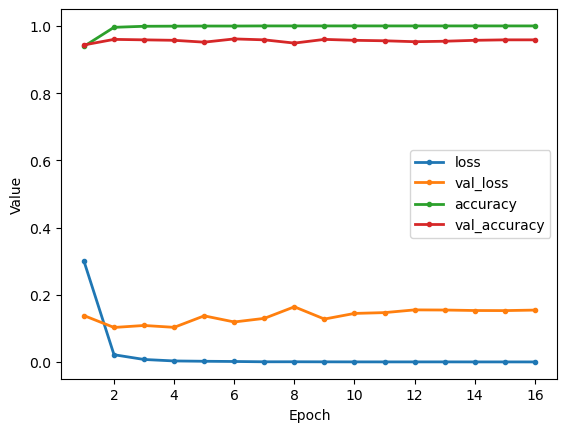

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [25]:
report.save()

Report saved as Output/Reports/HB-other/report_H55M1N7F.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################